In [3]:
using Revise
using RDDIP
using Random
using Plots
using Gurobi
using Statistics
const GRB_ENV = Gurobi.Env()
optimizer=() -> Gurobi.Optimizer(GRB_ENV)

Set parameter Username
Set parameter LicenseID to value 2658456
Academic license - for non-commercial use only - expires 2026-04-28


#15 (generic function with 1 method)

In [121]:
instance=RDDIP.parse_nc4("Data/T-Ramp/10_0_1_w.nc4",  optimizer, 24); instance.N
# instance.Demandbus

10

In [141]:
res=RDDIP.bin_extensive_neutral_integer(instance; K=4, silent=false, gap=0.0001, timelimit=10);

Set parameter TimeLimit to value 10
Set parameter Threads to value 1
Set parameter MIPGap to value 0.0001
Set parameter MIPGap to value 0.0001
Set parameter Threads to value 1
Set parameter TimeLimit to value 10
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 22 physical cores, 22 logical processors, using up to 1 threads

Non-default parameters:
TimeLimit  10
Threads  1

Optimize a model with 3542 rows, 2626 columns and 12422 nonzeros
Model fingerprint: 0x0e990aae
Variable types: 896 continuous, 1730 integer (1730 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 291 rows and 273 columns
Presolve time: 0.02s
Presolved: 3251 rows, 2353 columns, 13199 nonzeros
Variable types: 513 continuous, 1840 integer (1604 binary)
Found heuristi

In [143]:
# res[2][1,:,1,:]
sum(res[end-2])
[sum(res[end][end-k:end]) for k in 0:20]
# res[end-2]

21-element Vector{Float64}:
  64167.60120274001
 137848.90057437101
 218448.0296764168
 303208.68902069953
 385783.2280447597
 467304.2151389667
 552003.4173449604
 639002.874670206
 726362.2955312027
 813019.3483981717
      ⋮
      1.086874716088314e6
      1.181306690690213e6
      1.2754455916800334e6
      1.3660495647019667e6
      1.4451137765296951e6
      1.5060002369024688e6
      1.5542953227972775e6
      1.5994634280793325e6
      1.6439219193368016e6

In [5]:
T = 24
graph=RDDIP.LinearGraph(T);

In [136]:
force = 0.0
UB = sum([max(RDDIP.SHEDDING_COST, RDDIP.CURTAILEMENT_COST)*sum(instance.Demandbus[b][t] for b in 1:size(instance.Next)[1]) for t in 1:T])
lipschitz_constant = maximum([max(RDDIP.SHEDDING_COST, RDDIP.CURTAILEMENT_COST)*sum(instance.Demandbus[b][t] for b in 1:size(instance.Next)[1]) for t in 1:T])
model = RDDIP.PolicyGraph(
    RDDIP.subproblem_builder_UC,
    instance,
    force,
    graph,
    sense = :Min,
    lipschitz_constant = lipschitz_constant,
    lower_bound = 0.0,
    upper_bound = UB,
    optimizer = optimizer,
)

A policy graph with 24 nodes.
 Node indices: 1, ..., 24


In [148]:
# model[2].lagrangian_upper.uncertainty
# t=22
# println(model[22].uppersubproblem)
# # println(model[2].subproblem)
# # UB
# # model[2].bellman_function.global_theta.cuts
# md = model[t].lagrangian_upper.model
# println(md)
# model[t].lagrangian_upper.cuts
# unset_silent(md)
# JuMP.optimize!(md)
model[6].upper_bellman_function.global_theta.vertices

100-element Vector{RDDIP.Vertex}:
 RDDIP.Vertex(1.3762782859047996e7, Dict(Symbol("power_integer[2,1]") => 0.0, Symbol("power_integer[4,2]") => 0.0, Symbol("power_integer[5,3]") => 0.0, Symbol("power_integer[3,1]") => 0.0, Symbol("power_integer[10,4]") => 1.0, Symbol("power_integer[10,2]") => 0.0, Symbol("power_integer[2,3]") => 0.0, Symbol("power_integer[5,1]") => 1.0, Symbol("power_integer[4,1]") => 0.0, Symbol("is_on[6]") => -0.0…), _[268], _[153])
 RDDIP.Vertex(1.4644936309438994e7, Dict(Symbol("power_integer[2,1]") => 0.0, Symbol("power_integer[4,2]") => 0.0, Symbol("power_integer[5,3]") => 0.0, Symbol("power_integer[3,1]") => 0.0, Symbol("power_integer[10,4]") => 0.0, Symbol("power_integer[10,2]") => 0.0, Symbol("power_integer[2,3]") => 0.0, Symbol("power_integer[5,1]") => 0.0, Symbol("power_integer[4,1]") => 0.0, Symbol("is_on[6]") => 1.0…), _[269], _[154])
 RDDIP.Vertex(1.2012873084460996e7, Dict(Symbol("power_integer[2,1]") => 0.0, Symbol("power_integer[4,2]") => 0.0, Symbol("

In [72]:
model[t].lagrangian_upper.cuts

3-element Vector{RDDIP.Cut2}:
 RDDIP.Cut2(8.784504174300002e6, 8.442034184700001e6, dual_var_fix_uncertainty[uncertainty[1]] + theta_23 ≤ 8.784504174300002e6, Dict(Symbol("is_on[1]") => -0.0, Symbol("power_integer[1,1]") => -0.0, Symbol("power_integer[1,3]") => -0.0, Symbol("power_integer[1,2]") => -0.0, Symbol("power_integer[1,4]") => -0.0))
 RDDIP.Cut2(9.627884032596e6, 9.3143822139e6, dual_var_fix_in[is_on[1]] + dual_var_fix_in[power_integer[1,4]] + dual_var_fix_uncertainty[uncertainty[1]] + theta_23 ≤ 9.627884032596e6, Dict(Symbol("is_on[1]") => 1.0, Symbol("power_integer[1,1]") => 0.0, Symbol("power_integer[1,3]") => 0.0, Symbol("power_integer[1,2]") => 0.0, Symbol("power_integer[1,4]") => 1.0))
 RDDIP.Cut2(595193.694224, 281519.013096, -3 dual_var_fix_in[power_integer[1,1]] + 3 dual_var_fix_in[power_integer[1,2]] + dual_var_fix_uncertainty[uncertainty[1]] + theta_23 ≤ 595193.694224, Dict(Symbol("is_on[1]") => 1.0, Symbol("power_integer[1,1]") => -0.0, Symbol("power_integer[1,3]")

In [150]:
RDDIP.train(model; iteration_limit = 10, duality_handler = RDDIP.LagrangianConicDuality(), sampling_scheme = RDDIP.RobustMonteCarlo())

┌ Warning: Re-training a model with existing cuts!
│ 
│ Are you sure you want to do this? The output from this training may be
│ misleading because the policy is already partially trained.
│ 
│ If you meant to train a new policy with different settings, you must
│ build a new model.
│ 
│ If you meant to refine a previously trained policy, turn off this
│ warning by passing `add_to_existing_cuts = true` as a keyword argument
│ to `RDDIP.train`.
│ 
│ In a future release, this warning may turn into an error.
└ @ RDDIP /home/mathis/Documents/RDDIP/src/algorithm.jl:1300


-------------------------------------------------------------------
         RDDIP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 24
  state variables : 50
  scenarios       : 1.00000e+00
  existing cuts   : true
options
  solver          : serial mode
  risk measure    : RDDIP.Expectation()
  sampling scheme : RDDIP.RobustMonteCarlo
subproblem structure
  VariableRef                             : [166, 166]
  AffExpr in MOI.EqualTo{Float64}         : [63, 63]
  AffExpr in MOI.GreaterThan{Float64}     : [35, 142]
  AffExpr in MOI.LessThan{Float64}        : [70, 120]
  VariableRef in MOI.EqualTo{Float64}     : [51, 51]
  VariableRef in MOI.GreaterThan{Float64} : [33, 33]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
  VariableRef in MOI.ZeroOne              : [71, 71]
numerical stability report
  matrix range     [2e-13, 1e+05]
  objective range  [1e+00, 3e+03]
  bounds range     [8e+06, 

RDDIP.TrainingResults(:iteration_limit, RDDIP.Log[RDDIP.Log(1, 1.8136644769732463e6, 1.8284515864751618e6, 2.351943016052246, 1, 4824, "S", false), RDDIP.Log(2, 1.8136644769732463e6, 1.8284515864751618e6, 4.276987075805664, 1, 4848, "S", false), RDDIP.Log(3, 1.813698342172099e6, 1.8284515864751628e6, 6.184417009353638, 1, 4872, "S", false), RDDIP.Log(4, 1.813698342172099e6, 1.8283602033071415e6, 8.167133092880249, 1, 4896, "S", false), RDDIP.Log(5, 1.813698342172099e6, 1.8283602033071397e6, 10.086120128631592, 1, 4920, "S", false), RDDIP.Log(6, 1.813698342172099e6, 1.8283602033071397e6, 12.12109899520874, 1, 4944, "S", false), RDDIP.Log(7, 1.813590537199032e6, 1.8283602033071378e6, 14.035825967788696, 1, 4968, "S", false), RDDIP.Log(8, 1.813590537199032e6, 1.8282445264904727e6, 16.006216049194336, 1, 4992, "S", false), RDDIP.Log(9, 1.813590537199032e6, 1.8282445264904732e6, 18.013981103897095, 1, 5016, "S", false), RDDIP.Log(10, 1.813590537199032e6, 1.8282445264904723e6, 19.98440599441

In [54]:
println(model[2].subproblem)
mod = model[2].subproblem
unset_silent(mod)
JuMP.optimize!(mod)

Min 43.169962 power_real[1] + 300 power_shedding[1] + 300 power_curtailement[1] + 1337.77358 is_on[1]_out + 172.862432 start_up[1] + _[23]
Subject to
 32 power_integer[1,1]_out + 60.66666666666667 power_integer[1,2]_out + 89.33333333333334 power_integer[1,3]_out + 118 power_integer[1,4]_out + power_dev[1] - power_real[1] = 0
 32 power_integer[1,1]_out + 60.66666666666667 power_integer[1,2]_out + 89.33333333333334 power_integer[1,3]_out + 118 power_integer[1,4]_out - power[1] = 0
 32 power_integer[1,1]_in + 60.66666666666667 power_integer[1,2]_in + 89.33333333333334 power_integer[1,3]_in + 118 power_integer[1,4]_in - power_prev[1] = 0
 -is_on[1]_out + power_integer[1,1]_out + power_integer[1,2]_out + power_integer[1,3]_out + power_integer[1,4]_out = 0
 -is_on[1]_in + power_integer[1,1]_in + power_integer[1,2]_in + power_integer[1,3]_in + power_integer[1,4]_in = 0
 -is_on[1]_in + is_on[1]_out - start_up[1] + start_down[1] = 0
 uncertainty[1] + uncertainty[2] = 1
 error_forecast[1] + unce

In [19]:
RDDIP.train(model; iteration_limit = 10, duality_handler = RDDIP.LagrangianConicDuality(), sampling_scheme = RDDIP.RobustMonteCarlo())

-------------------------------------------------------------------
         RDDIP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 24
  state variables : 50
  scenarios       : 8.38861e+06
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : RDDIP.Expectation()
  sampling scheme : RDDIP.RobustMonteCarlo
subproblem structure
  VariableRef                             : [166, 167]
  AffExpr in MOI.EqualTo{Float64}         : [63, 63]
  AffExpr in MOI.GreaterThan{Float64}     : [30, 80]
  AffExpr in MOI.LessThan{Float64}        : [70, 120]
  VariableRef in MOI.EqualTo{Float64}     : [1, 2]
  VariableRef in MOI.GreaterThan{Float64} : [33, 83]
  VariableRef in MOI.LessThan{Float64}    : [1, 51]
  VariableRef in MOI.ZeroOne              : [71, 72]
numerical stability report
  matrix range     [1e+00, 3e+02]
  objective range  [1e+00, 3e+03]
  bounds range     [1e+00, 8

RDDIP.TrainingResults(:iteration_limit, RDDIP.Log[RDDIP.Log(1, 72836.70836867209, 1.125479323694288e7, 1.3141539096832275, 1, 117, "S", false), RDDIP.Log(2, 302329.4405110329, 1.9474209779846873e6, 2.3097169399261475, 1, 234, "S", false), RDDIP.Log(3, 1.5237700006381765e6, 1.9474209779846873e6, 3.2443010807037354, 1, 351, "S", false), RDDIP.Log(4, 1.6620800954305881e6, 1.9474209779846873e6, 4.223033905029297, 1, 468, "S", false), RDDIP.Log(5, 1.7358870832400867e6, 1.9474209779846873e6, 5.389512062072754, 1, 585, "S", false), RDDIP.Log(6, 1.754893321353349e6, 1.9474209779846873e6, 6.364487886428833, 1, 702, "S", false), RDDIP.Log(7, 1.7604014603122855e6, 1.9474209779846873e6, 7.617690086364746, 1, 819, "S", false), RDDIP.Log(8, 1.783320074888651e6, 1.9474209779846873e6, 9.002341032028198, 1, 936, "S", false), RDDIP.Log(9, 1.7854206683653332e6, 1.9474209779846873e6, 10.5484299659729, 1, 1053, "S", false), RDDIP.Log(10, 1.793687888721795e6, 1.9474209779846873e6, 11.692262887954712, 1, 117

In [17]:
# Random.seed!(12345)
RDDIP.train(model; iteration_limit = 50, duality_handler = RDDIP.LagrangianDuality(), sampling_scheme = RDDIP.RobustMonteCarlo())
# RDDIP.train(model; iteration_limit = 1, duality_handler = RDDIP.LagrangianConicDuality(), sampling_scheme = RDDIP.RobustMonteCarlo())

# RDDIP.train(model; iteration_limit = 1, duality_handler = RDDIP.LagrangianConicDuality())

-------------------------------------------------------------------
         RDDIP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 24
  state variables : 50
  scenarios       : 8.38861e+06
  existing cuts   : true
options
  solver          : serial mode
  risk measure    : RDDIP.Expectation()
  sampling scheme : RDDIP.RobustMonteCarlo
subproblem structure
  VariableRef                             : [166, 167]
  AffExpr in MOI.EqualTo{Float64}         : [63, 63]
  AffExpr in MOI.GreaterThan{Float64}     : [31, 90]
  AffExpr in MOI.LessThan{Float64}        : [70, 120]
  VariableRef in MOI.EqualTo{Float64}     : [51, 52]
  VariableRef in MOI.GreaterThan{Float64} : [33, 33]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
  VariableRef in MOI.ZeroOne              : [71, 72]
numerical stability report
  matrix range     [1e+00, 4e+04]
  objective range  [1e+00, 3e+03]
  bounds range     [8e+06, 8

┌ Warning: Re-training a model with existing cuts!
│ 
│ Are you sure you want to do this? The output from this training may be
│ misleading because the policy is already partially trained.
│ 
│ If you meant to train a new policy with different settings, you must
│ build a new model.
│ 
│ If you meant to refine a previously trained policy, turn off this
│ warning by passing `add_to_existing_cuts = true` as a keyword argument
│ to `RDDIP.train`.
│ 
│ In a future release, this warning may turn into an error.
└ @ RDDIP /home/mathis/Documents/RDDIP/src/algorithm.jl:1286


-------------------------------------------------------------------
 iteration    lower bound      upper bound        time (s)     solves  pid
-------------------------------------------------------------------
         1L  1.824874e+06  1.947421e+06  1.363649e+00      1287   1
         2L  1.845879e+06  1.947421e+06  2.707147e+00      1404   1


ArgumentError: ArgumentError: matrix contains Infs or NaNs

In [7]:
Random.seed!(12345)
RDDIP.train(model; iteration_limit = 100, duality_handler = RDDIP.StrengthenedConicDuality())
# RDDIP.train(model; iteration_limit = 1, duality_handler = RDDIP.LagrangianConicDuality())

-------------------------------------------------------------------
         RDDIP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 24
  state variables : 183
  scenarios       : 1.00000e+00
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : RDDIP.Expectation()
  sampling scheme : RDDIP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [432, 432]
  AffExpr in MOI.EqualTo{Float64}         : [196, 196]
  AffExpr in MOI.GreaterThan{Float64}     : [30, 213]
  AffExpr in MOI.LessThan{Float64}        : [90, 273]
  VariableRef in MOI.GreaterThan{Float64} : [33, 216]
  VariableRef in MOI.LessThan{Float64}    : [183, 184]
  VariableRef in MOI.ZeroOne              : [204, 204]
numerical stability report
  matrix range     [1e+00, 3e+02]
  objective range  [1e+00, 3e+03]
  bounds range     [1e+00, 1e+00]
  rhs range        [1e+00, 1e+03]

RDDIP.TrainingResults(:iteration_limit, RDDIP.Log[RDDIP.Log(1, 1.379666532551001e6, 1.8675235047577259e6, 1.3014509677886963, 1, 25, "S", false), RDDIP.Log(2, 1.7470327019469077e6, 1.9553782612850287e6, 1.9013519287109375, 1, 50, "S", false), RDDIP.Log(3, 1.7944937261608883e6, 1.9133746198074454e6, 2.4956469535827637, 1, 75, "S", false), RDDIP.Log(4, 1.795050564603704e6, 1.9109293785461737e6, 3.1026158332824707, 1, 100, "S", false), RDDIP.Log(5, 1.8019079054378115e6, 2.178056370593232e6, 3.6622278690338135, 1, 125, "S", false), RDDIP.Log(6, 1.8081045267066255e6, 1.865059554394934e6, 4.851253986358643, 1, 150, "S", false), RDDIP.Log(7, 1.8085103651415866e6, 1.9940315719081874e6, 5.5180017948150635, 1, 175, "S", false), RDDIP.Log(8, 1.8091502880411693e6, 1.9421382399238527e6, 6.163815021514893, 1, 200, "S", false), RDDIP.Log(9, 1.809504696030763e6, 1.898891703166961e6, 6.876116991043091, 1, 225, "S", false), RDDIP.Log(10, 1.8103704667298272e6, 1.9145986076947337e6, 7.512825012207031, 1, 

In [92]:
using JuMP

model = Model()
@variable(model, x >= 0)
@variable(model, y >= 0)
@constraint(model, c1, x + y <= 10)
cstr = @constraint(model, c2, 2x - y >= 3)


# cons = all_constraints(model; include_variable_in_set_constraints=true)
# println(cons)

f = JuMP.constraint_object(cstr).func

f.terms
s = JuMP.constraint_object(cstr).set

if s isa MOI.GreaterThan
    println("C’est une contrainte de type ≥ avec borne = ", s.lower)
elseif s isa MOI.LessThan
    println("C’est une contrainte de type ≤ avec borne = ", s.upper)
elseif s isa MOI.EqualTo
    println("C’est une contrainte de type = avec borne = ", s.value)
else
    println("Autre type de contrainte")
end
for (i,k) in f.terms
    println((i,k))
end
# typeof(JuMP.name(x))

C’est une contrainte de type ≥ avec borne = 3.0
(x, 2.0)
(y, -1.0)


In [ ]:
RDDIP.TrainingResults(:iteration_limit, RDDIP.Log[RDDIP.Log(1, 1.428402521661652e6, 1.8350314844269806e6, 3.765532970428467, 1, 140, "S", false), RDDIP.Log(2, 1.4869460945114475e6, 1.9150885666642494e6, 9.079401969909668, 1, 280, "S", false)])

In [ ]:
res=RDDIP.train(model; iteration_limit = 2, print_level = 0, duality_handler = RDDIP.RDDIP.LagrangianConicDuality())

In [28]:
# string([res.log[i].simulation_value for i in 1:length(res.log)])
1.8574247832686587e6

1.8574247832686587e6

In [ ]:
println(model[23].subproblem)

In [101]:
# Création du modèle
model = Model(optimizer)

@variable(model, x >= 0)
@variable(model, y >= 0)
@objective(model, Max, 3x + 5y)
@constraint(model, 2x + 3y <= 12)

optimize!(model)
Dict(name(v) => value(v) for v in all_variables(model))


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 22 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0x3d56774b
Coefficient statistics:
  Matrix range     [2e+00, 3e+00]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+01]
Presolve removed 1 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.000000000e+01

User-callback calls 42, time in user-callback 0.00 sec


Dict{String, Float64} with 2 entries:
  "x" => 0.0
  "y" => 4.0

In [ ]:
println(model[23].subproblem)
# mod = model[23].subproblem
# optimize!(mod)

In [ ]:
node = model[23]
for (key, state) in node.states
    # println((key, value(state.in), JuMP.is_integer(state.in), JuMP.upper_bound(state.in)))
    println((key, state.out, JuMP.is_binary(state.out), node.incoming_state_bounds[key]))
    # println((key, value(state.in), JuMP.is_integer(state.in)))
    # println(JuMP.upper_bound(state.in))
end
JuMP.upper_bound(collect(values(node.states))[1].in)
# collect(values(node.states))[1].in


In [ ]:
println(model[1].subproblem)

In [ ]:
1.806476027737761e6, 1.8289582420327545e6

In [61]:
mod = JuMP.Model(optimizer)
@variable(mod, x, Bin)
@variable(mod, y )
@objective(mod, Max, x)
# JuMP.optimize!(mod)
# JuMP.termination_status(mod)
undo_relax = JuMP.relax_integrality(mod)
println(mod)
# undo_relax()
# JuMP.upper_bound(x)
using Dualization
md=dualize(mod)
println(md)

Max x
Subject to
 x ≥ 0
 x ≤ 1

Min -_[1]
Subject to
 0 = 0
 -_[1] ≥ 1
 _[1] ≤ 0



In [111]:
using Dualization
mod = JuMP.Model(optimizer)
@variable(mod, x)
@variable(mod, y)
@constraint(mod, s,x + y <= 10)
@objective(mod, Min, x)

new_model, reference_map = copy_model(mod)
@constraint(new_model, fix_x, reference_map[x] == 1.0)
println(new_model)

md=dualize(new_model; dual_names = DualNames("dual_var_", "dual_con_"))
# println(md)
# reference_map[s]
hexpr = JuMP.objective_function(md)
println(md)
@variable(md, z)
@constraint(md, z <= hexpr)
@objective(md, Max, z)
println(md)
md[Symbol("dual_var_", "s")]

Min x
Subject to
 fix_x : x = 1
 s : x + y ≤ 10

Max 10 dual_var_s + dual_var_fix_x
Subject to
 dual_con_x : dual_var_fix_x + dual_var_s = 1
 dual_con_y : dual_var_s = 0
 dual_var_s ≤ 0

Max z
Subject to
 dual_con_x : dual_var_fix_x + dual_var_s = 1
 dual_con_y : dual_var_s = 0
 -dual_var_fix_x - 10 dual_var_s + z ≤ 0
 dual_var_s ≤ 0



dual_var_s

In [16]:
using Suppressor, Dualization
node = model[24]
mod = node.subproblem
undo_relax = JuMP.relax_integrality(mod)
new_model, reference_map = @suppress copy_model(mod)
undo_relax()
copy_state_out = Dict()
copy_state_in = Dict()
copy_uncertainty = Dict()
# for (name,state) in node.states
#     copy_state_out[name] = JuMP.variable_by_name(new_model, string(name,"_out"))
#     copy_state_in[name] = JuMP.variable_by_name(new_model, string(name,"_in"))
# end
# for (name,uncertainty) in node.uncertainties
#     # println(name, uncertainty)
#     copy_uncertainty[name] = JuMP.variable_by_name(new_model, string(name))
# end
# @constraint(new_model, fix_out[name in keys(copy_state_out)], copy_state_out[name] == 1.0)
# @constraint(new_model, fix_in[name in keys(copy_state_in)], copy_state_in[name] == 0.0)
# @constraint(new_model, fix_uncertainty[name in keys(copy_uncertainty)], copy_uncertainty[name] == 0.0)
# println(new_model)
# md=dualize(new_model; consider_constrained_variables=false, dual_names = DualNames("dual_var_", "dual_con_"))
# hexpr = JuMP.objective_function(md)
# @variable(md, θ)
# @constraint(md, θ <= hexpr)
# @objective(md, Max, θ)
# println(md)
# dual_variables_states_out = Dict(name => md[Symbol("dual_var_fix_out[$name]")] for name in keys(copy_state_out))
# dual_variables_states_in = Dict(name => md[Symbol("dual_var_fix_in[$name]")] for name in keys(copy_state_in))
# dual_variables_uncertainty = Dict(name => md[Symbol("dual_var_fix_uncertainty[$name]")] for name in keys(copy_uncertainty))

Dict{Any, Any}()

In [85]:
lagrangian = model[24].lagrangian
cstr = lagrangian.upper_constraint
var = dual_variables_states_out[Symbol("power_integer[1,1]")]
set_normalized_coefficient(cstr, var, -1)
set_normalized_rhs(cstr, 3)
cstr

-_[7] - 1034.95728 _[9] - _[32] - _[37] - _[38] - _[39] - _[40] - _[41] - _[62] - _[63] - _[64] - _[65] - _[66] - _[67] - _[68] - _[69] - _[70] - _[71] - _[72] - _[73] - _[74] - _[75] + theta_24 - dual_var_fix_out[power_integer[1,1]] ≤ 3

In [8]:
using JuMP, Dualization
model = Model()
@variable(model, x)
@variable(model, y)
@variable(model, z)
@constraint(model, soccon, [x; y; z] in SecondOrderCone())
@constraint(model, eqcon, x == 1)
@objective(model, Min, y + z)
dual_model = dualize(model; consider_constrained_variables=false, dual_names = DualNames("", ""))
println(dual_model)

Max eqcon
Subject to
 x : eqcon + soccon_1 = 0
 y : soccon_2 = 1
 z : soccon_3 = 1
 [soccon_1, soccon_2, soccon_3] ∈ MathOptInterface.SecondOrderCone(3)



In [65]:
new_model

A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 23
├ num_constraints: 68
│ ├ AffExpr in MOI.EqualTo{Float64}: 21
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 12
│ ├ VariableRef in MOI.EqualTo{Float64}: 7
│ ├ VariableRef in MOI.GreaterThan{Float64}: 13
│ └ VariableRef in MOI.LessThan{Float64}: 7
└ Names registered in the model
  └ :error_forecast, :fix_in, :fix_out, :fix_uncertainty, :flow, :power, :power_curtailement, :power_dev, :power_prev, :power_real, :power_shedding, :start_down, :start_up, :θ

In [66]:
dualize(new_model)

A JuMP Model
├ solver: none
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 51
├ num_constraints: 46
│ ├ AffExpr in MOI.EqualTo{Float64}: 6
│ ├ AffExpr in MOI.GreaterThan{Float64}: 13
│ ├ VariableRef in MOI.GreaterThan{Float64}: 8
│ └ VariableRef in MOI.LessThan{Float64}: 19
└ Names registered in the model: none

In [74]:
using JuMP, Dualization, LinearAlgebra

# Ton modèle original
model = Model()
@variable(model, x1 >= 0)
@variable(model, x2)
@constraint(model, x2 == 4)
@constraint(model, 2x1 - x2 >= 1)
@constraint(model, x1 + x2 <= 3)
@objective(model, Min, x1 + 2x2)

# --- Étape 1 : standardiser ---
# Dualization.jl fournit un utilitaire pour cela :
# standard_model = Dualization.standard_form(model)

# --- Étape 2 : dualiser ---
dual_model = dualize(model)

println("Nb variables primal standardisé: ", num_variables(model))
# println("Nb contraintes dual: ", num_constraints(dual_model))
println(dual_model)

Nb variables primal standardisé: 2
Max _[2] + 3 _[3] + 4 _[1]
Subject to
 _[1] - _[2] + _[3] = 2
 -2 _[2] - _[3] ≥ -1
 _[2] ≥ 0
 _[3] ≤ 0



In [59]:
println(model[2].lagrangian.model)

Max theta_2
Subject to
 dual_con_power_dev[1] : _[1] + _[22] + _[30] = 0
 dual_con_θ[1] : 0 = 0
 dual_con_error_forecast[1] : _[8] - 44.209449242 _[9] = 0
 dual_con_uncertainty[2] : _[7] + 0.5 _[8] + dual_var_fix_uncertainty[uncertainty[2]] + _[42] = 0
 dual_con_start_down[1] : -_[6] - _[32] - 32.599073 _[36] - _[46] ≥ 0
 dual_con_start_up[1] : _[6] - _[31] - 42.003808 _[35] - _[45] ≥ -172.862432
 dual_con_power_integer[1,4]_out : -118 _[1] - 118 _[2] - _[4] - dual_var_fix_out[power_integer[1,4]] - _[54] ≥ 0
 dual_con_power[1] : _[2] - _[23] - _[33] ≥ 0
 dual_con_ : 0 ≥ -1
 dual_con_power_integer[1,3]_in : -89.33333333333334 _[3] - _[5] - dual_var_fix_in[power_integer[1,3]] - _[27] - _[39] - _[51] ≥ 0
 dual_con_power_integer[1,1]_out : -32 _[1] - 32 _[2] - _[4] - dual_var_fix_out[power_integer[1,1]] - _[48] ≥ 0
 dual_con_power_curtailement[1] : _[9] ≥ -300
 dual_con_power_integer[1,2]_out : -60.66666666666667 _[1] - 60.66666666666667 _[2] - _[4] - dual_var_fix_out[power_integer[1,2]] -

In [ ]:
mod = model[2].lagrangian.model
# set_optimizer(mod, optimizer)
set_optimizer_attribute(mod, "Presolve", 0)
println(mod)
unset_silent(mod)  # Remet les sorties du solveur
optimize!(mod)
println("Termination status: ", JuMP.termination_status(mod))
println("Primal status:     ", JuMP.primal_status(mod))
Dict(i =>value.(var) for (i, var) in model[2].lagrangian.dual_variables)
for (i, var) in model[2].lagrangian.dual_variables
    if abs(value(var)) > 1e-6
        println("Variable ", i, " has value ", value(var))
    end
end
println(value(model[2].lagrangian.theta))

In [12]:
using XLSX

# Ouvre le fichier Excel
xlsx = XLSX.readxlsx("results_1000.xlsx")

XLSXFile("results_1000.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
              results 3x4           A1:D3        


In [ ]:
Lower_bound = Dict()
Upper_bound = Dict()
computation_time = Dict()
for i in 2:3
    name = xlsx["results"]["A$i"]
    A = xlsx["results"]["B$i"]
    B = parse.(Float64, split(strip(A, ['[', ']']), ","))
    C = xlsx["results"]["D$i"]
    Lower_bound[name] = B
    computation_time[name] = parse.(Float64, split(strip(C, ['[', ']']), ","))
end

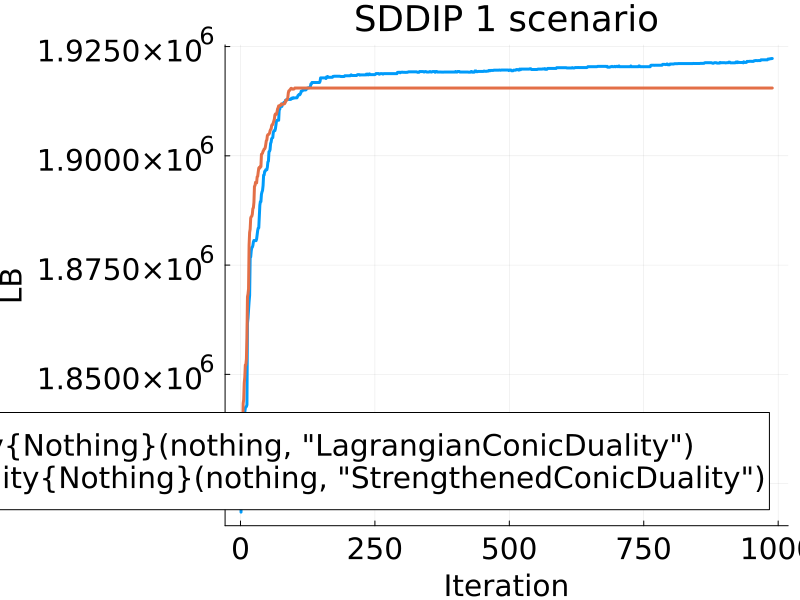

In [14]:
K=12
N=1000
using Plots
p = plot(title="SDDIP 1 scenario",
     xlabel="Iteration",
     ylabel="LB",
    #  lw=2,                # largeur des lignes
     legend=:bottomright,
    titlefontsize=24, 
    guidefontsize=20, 
    tickfontsize=20, 
    legendfontsize=20,
    size=(800, 600),
    linewidth=3, )     # position de la légende

for (nom, valeurs) in Lower_bound
    plot!(1:length(valeurs[K:end]), valeurs[K:end], label=nom, linewidth=3)
end
# plot!([N for N in 1:N-K], [1827475 for N in 1:N-K], color=:black, linewidth=3, label="UB")

display(p)
# savefig("SDDIP1.png")

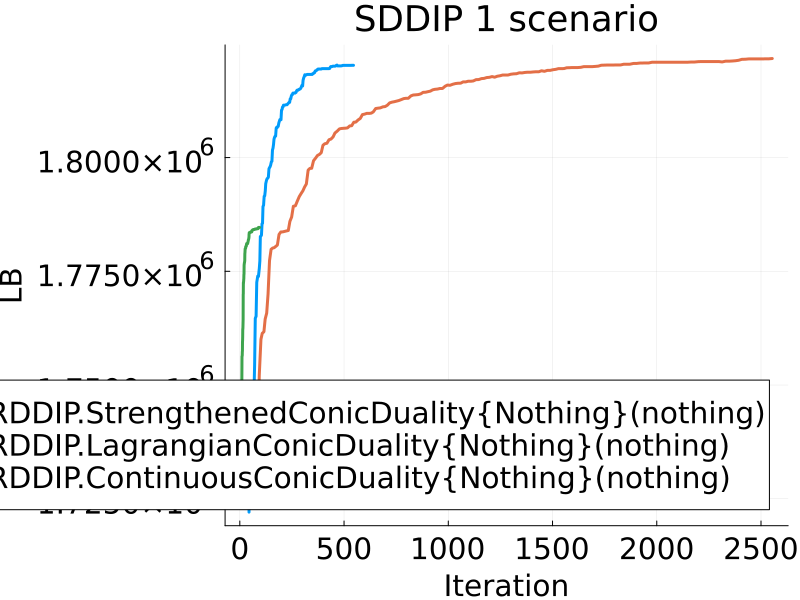

In [30]:
K=12
N=1000
using Plots
p = plot(title="SDDIP 1 scenario",
     xlabel="Iteration",
     ylabel="LB",
    #  lw=2,                # largeur des lignes
     legend=:bottomright,
    titlefontsize=24, 
    guidefontsize=20, 
    tickfontsize=20, 
    legendfontsize=20,
    size=(800, 600),
    linewidth=3, )     # position de la légende

for (nom, valeurs) in Lower_bound
    # plot!(1:length(valeurs[K:end]), valeurs[K:end], label=nom, linewidth=3)
    plot!(computation_time[nom][K:end], valeurs[K:end], label=nom, linewidth=3)
end
# plot!([N for N in 1:2500-K], [1827475 for N in 1:2500-K], color=:black, linewidth=3, label="UB")

display(p)
# savefig("SDDIP1time.png")

In [50]:
import Pkg

In [ ]:
Pkg.